## 5. Ground Filters, Bare Earth Models and Normalization

One of the most integral parts of LiDAR analysis is determining which points represent the ground. Once this step is completed, we can construct bare earth models (BEMs) and normalize our point clouds to produce reliable estimates of height, canopy height models and other products. 

pyfor has a dedicated module for handling ground filters, BEMs and normalization, `pyfor.ground_filter` and implements two major ground filtering algorithms, `KrausPfeifer1998` and `Zhang2003`. The user is free to use these classes, which are lower level implementations of the filters, or use the convenience wrappers in the `Cloud` object for quick default implementations.

Ground filter classes provide access to three things:
    1. Bare Earth Models
    2. Ground Points
    3. Normalized Point Clouds 

## Normalization - The Quick Way

Many of you just want to normalize quickly and be done with the whole mess. Follow the instructions below to get a decent normalized point cloud. The default normalization uses the `Zhang20003` filter which was developed in [Zhang et al. (2003)](https://ieeexplore.ieee.org/abstract/document/1202973).

In [2]:
import pyfor

# Load the point cloud
pc = pyfor.cloud.Cloud("my_las.las")

# Plot the raw cloud
pc.iplot3d(point_size=2)

<img src="images/raw_iplot.png" width="550">

In [13]:
# Call the normalization functions with some useful settings for the algorithm.
pc.normalize(cell_size=5)

<img src="images/norm_iplot.png" width="550">

As we can see, the point cloud is now normalized and ready for metric extraction.

## Bare Earth Model (BEM)

Sometimes it is advantageous to view the bare earth model by itself as its own object. This way, we can diagnose the performance of our normalization routine, and save the BEM to its own file for other uses. This can be done via lower-level standalone ground filters stored in the `ground_filter` module. Standalone ground filters allow us to access much more information than the convenience wrappers in the previous section.

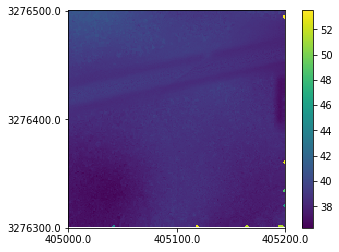

In [8]:
# Import the filter
from pyfor.ground_filter import KrausPfeifer1998

# Load the point cloud
pc = pyfor.cloud.Cloud("../data/test.las")

# Instantiate the filter and construct BEM
kp_filter = KrausPfeifer1998(pc, cell_size=4)
bem = kp_filter.bem(1)
bem.plot()

Calling `.bem` on our filter object returns a `Raster` object, complete with its own plotting and writing function. We can now easily diagnose our ground filter and adjust our parameters as needed.

`Raster` objects have many useful features. For advanced users, we can access the numpy array of values where each element of the array corresponds to the `z` value in our BEM.

In [9]:
bem.array

array([[40.46, 40.46, 40.89, ..., 39.11, 39.11, 39.11],
       [40.52, 40.55, 40.55, ..., 38.76, 38.76, 38.76],
       [40.65, 40.74, 40.87, ..., 38.76, 38.76, 38.76],
       ...,
       [37.23, 37.21, 36.75, ..., 38.28, 38.28, 38.28],
       [37.23, 37.21, 36.75, ..., 51.55, 38.28, 38.28],
       [37.23, 37.21, 36.75, ..., 51.55, 51.55, 38.28]])

Finally, if we have a coordinate reference system set to the "parent" `Cloud` object, we can save the file.

In [14]:
import pyproj
pc.crs = pyproj.Proj("+init=EPSG:4326").srs
bem.write("my_bem.tif")

## Ground Points

Sometimes we will need access to the ground points themselves. This may be the case if we want to combine filters or save the ground points as its own point cloud. We can do this with our `kp_filter` object. Each instance of a filter has a `.ground_points` attribute, which returns a new `Cloud` object with only the points we desire.

Below we display the first 5 point records of the `Cloud.data.points` attribute.

In [10]:
ground = kp_filter.ground_points
ground.data.points.head()

,x,y,z,intensity,return_num,classification,flag_byte,scan_angle_rank,user_data,pt_src_id,bins_x,bins_y,bins_z
77352.0,405003.82,3276499.93,40.96,0,2,1,82,3,4,12,0,0,0
78005.0,405003.60,3276499.57,40.47,0,1,2,9,3,0,12,0,0,1
78009.0,405000.13,3276499.85,40.97,0,2,1,18,3,5,12,0,0,5
78010.0,405000.09,3276499.33,40.90,0,1,1,73,3,5,12,0,0,6
78012.0,405000.78,3276499.28,40.85,0,2,1,82,3,4,12,0,0,8


## Normalization (The Slighlty Harder Way)

We can also directly normalize with an instantiated ground filter. Here, we will do so with the `Zhang2003` filter. This provides direct control over the behavior of the filter via its instantiation settings.

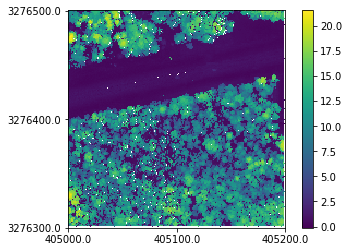

In [13]:
from pyfor.ground_filter import Zhang2003

zhang_filter = Zhang2003(pc, 2, n_windows=5, dh_max=2, dh_0=1, b=2, interp_method="nearest")
zhang_filter.normalize()

pc.plot()